# 02-01: Analisi distribuzione custom

**1. Consideriamo dei componenti meccanici delicati che hanno tempi di vita casuali con distribuzione a due parametri $a>0$, $b>0$, che segue questa formula:**

$$F(t)=P(T \le t) = 1 - e^{(-at^2-bt)}$$

**1.1 Generare un campione con questa legge, con $a=0.01$ e $b=0.01$, tracciarne la densità e stimare media e deviazione standard al $95\%$ di confidenza. Stimare anche la mediana puntualmente.**

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous
import pandas as pd

In [2]:
a = 0.01
b = 0.01
n_samples = 1000

f = lambda t: 1 - np.exp(-a * (t**2) -b * t)

In [3]:

x = np.linspace(1,20, n_samples)

Prendi un valore $u \in (0,1)$, lo interpreti come probabilità cumulativa, e poi fai $t = F^{-1}(u)$. Questo si chiama inverse transform sampling.

# Creazione di una distribuzione custom in SciPy

In [4]:
class CustomDist(rv_continuous):
    def _cdf(self, t, a, b):
        return 1 - np.exp(-a * (t**2) -b * t)

    def _pdf(self, t, a, b):
        return (2*a*t + b) * np.exp(-(a*t*t + b*t))
    
    def _support(self, a, b):
        return 0, np.inf


dist = CustomDist(a=0, name="custom")
samples = dist.rvs(a=0.01, b=0.01, size=1000)

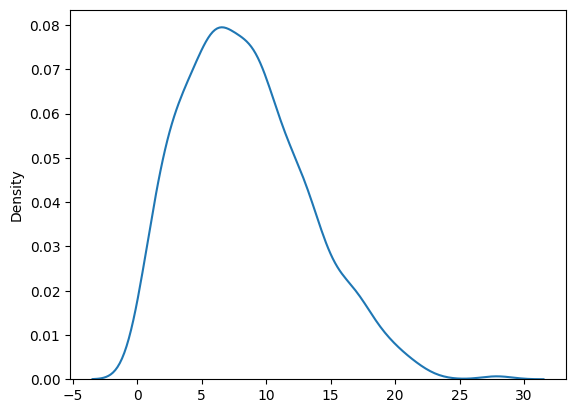

In [5]:
sns.kdeplot(samples)
plt.show()

## Stima della media con IC

In [6]:
from scipy.stats import t
import numpy as np

conf = 0.95
alpha = 1 - conf

n = len(samples)
mean = np.mean(samples)
s = np.std(samples, ddof=1)          # deviazione standard campionaria
df = n - 1

q = t.ppf(1 - alpha/2, df)     # quantile critico t

margin = q * s / np.sqrt(n)

ci_low  = mean - margin
ci_high = mean + margin

print(f"IC {conf:.0%} per la media: [{ci_low:.6f}, {ci_high:.6f}]")

IC 95% per la media: [8.084911, 8.677167]


In [7]:
from scipy.stats import chi2
import numpy as np

conf = 0.95
alpha = 1 - conf

n = len(samples)
s2 = np.var(samples, ddof=1)          # varianza campionaria
df = n - 1

q_low  = chi2.ppf(alpha/2, df)        # quantile basso
q_high = chi2.ppf(1 - alpha/2, df)    # quantile alto

ci_low  = df * s2 / q_high
ci_high = df * s2 / q_low

print(f"IC {conf:.0%} per la varianza: [{ci_low:.6f}, {ci_high:.6f}]")
print(f"IC {conf:.0%} per la std: [{np.sqrt(ci_low):.6f}, {np.sqrt(ci_high):.6f}]")

IC 95% per la varianza: [20.900328, 24.909353]
IC 95% per la std: [4.571688, 4.990927]


## Calcolo della mediana

In [8]:
median = np.median(samples)
print(f"Median: {median}")

Median: 7.903974478311714


## MLE dei parametri custom

**1.2 Calcolare gli stimatori MLE di a e b per questa distribuzione, a partire dal campione qui a fianco.**

In [9]:
base = pd.read_excel("inml25tst02.xlsx", sheet_name="Es 1", header=None)
df = base.drop(columns=base.columns[:-1])
df.columns = ["Values"]

In [10]:
df.head()

,Values
0,272
1,49
2,189
3,101
4,131


In [11]:
T = df["Values"].values

In [12]:
a_range = np.linspace(1e-3, 1e-5, 100)
b_range = np.linspace(1e-3,1e-5, 100)

lkl = []

##########################
# STIMA DI A_0 - B_0
##########################

m1 = T.mean()
m2 = (T**2).mean()

a0 = 0.5 / m2
b0 = 0.5 / m1

##########################

for a_val in a_range:
    for b_val in b_range:
        lkl.append((a_val, b_val, dist.logpdf(T, a=a_val, b=b_val).mean()))

In [13]:
lkl = np.array(lkl)

In [14]:
idx = np.argsort(lkl[:, 2])[::-1]
lkl_sorted = lkl[idx]
best_a, best_b, best_lkl = lkl_sorted[0]

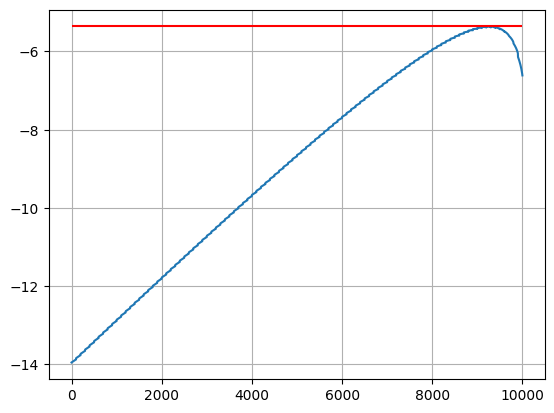

In [15]:
plt.plot(range(lkl.shape[0]), lkl[:,2])
plt.hlines(best_lkl, 0, lkl.shape[0], 'r')
plt.grid()
plt.show()

In [16]:
print(f"Best a: {best_a:.5f}")
print(f"Best b: {best_b:.5f}")
print(f"Best likelihood: {best_lkl:.5f}")

Best a: 0.00008
Best b: 0.00100
Best likelihood: -5.36027


## Test di adattamento per la distribuzione Gamma

**Sempre per il campione qui a fianco, verificare con un test di adattamento se può appartenere invece alla distribuzione gamma.**

In [17]:
import numpy as np
from scipy.stats import gamma, chisquare

k = 5
n = len(samples)

# --- FIT GAMMA ---
# Versione A (consigliata se y > 0): Gamma con supporto (0, +inf) -> loc fissato a 0
a, loc, scale = gamma.fit(samples, floc=0)
ddof = 2  # parametri stimati: a (shape), scale

# # Versione B (più flessibile): stima anche loc (3 parametri)
# a, loc, scale = gamma.fit(y)
# ddof = 3  # parametri stimati: a, loc, scale

di = gamma(a=a, loc=loc, scale=scale)

# bordi ai quantili 1/k, 2/k, ..., (k-1)/k, con estremi infiniti
edges = di.ppf(np.arange(1, k) / k)
edges = np.r_[-np.inf, edges, np.inf]

obsg, _ = np.histogram(samples, bins=edges)

# sotto H0 (Gamma stimata), ogni classe ha probabilità 1/k -> attese tutte n/k
expg = np.full(k, n / k)

statistic, pvalue = chisquare(obsg, f_exp=expg, ddof=ddof)
print(f"Gamma fit: a={a:.6g}, loc={loc:.6g}, scale={scale:.6g}")
print(f"Statistic: {statistic}")
print(f"P-value: {pvalue}")


Gamma fit: a=2.43714, loc=0, scale=3.43889
Statistic: 16.57
P-value: 0.00025227267797412796
